Capstone Project

Tornado Analysis

In [358]:
pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.1/99.8 MB 381.3 kB/s eta 0:04:22
   ---------------------------------------- 0.1/99.8 MB 467.6 kB/s eta 0:03:34
   ---------------------------------------- 0.2/99.8 MB 765.3 kB/s eta 0:02:11
   ---------------------------------------- 0.5/99.8 MB 1.5 MB/s eta 0:01:05
   ---------------------------------------- 0.9/99.8 MB 2.3 MB/s eta 0:00:43
    --------------------------------------- 

In [365]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 495.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.3 MB 1.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 2.4 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.3 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [367]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/spc.csv')

In [3]:
df

,om,yr,mo,dy,date,time,tz,st,stf,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.7300,-102.5200,36.8800,-102.3000,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,3,3,0,5.0,0.0,34.1700,-78.6000,0.0000,0.0000,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,2,0,0,5.0,0.0,37.3700,-87.2000,0.0000,0.0000,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,1,0,0,5.0,0.0,38.2000,-84.5000,0.0000,0.0000,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,1,3,0,4.0,0.0,32.4200,-89.1300,0.0000,0.0000,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68696,621922,2022,9,28,2022-09-28,13:32:00,3,FL,12,0,0,0,0,0.0,0.0,28.0830,-80.8669,28.1249,-80.8841,3.00,100,1,1,1,9,0,0,0,0
68697,621923,2022,9,30,2022-09-30,10:25:00,3,NC,37,0,0,0,0,0.0,0.0,33.9128,-78.2882,33.9132,-78.3011,0.74,20,1,1,1,19,0,0,0,0
68698,621924,2022,9,30,2022-09-30,13:22:00,3,NC,37,0,-9,0,0,0.0,0.0,35.3242,-76.7076,35.3325,-76.7147,0.70,12,1,1,1,13,0,0,0,0
68699,621900,2022,9,4,2022-09-04,15:44:00,3,OH,39,0,0,0,0,12000.0,0.0,41.0210,-80.6559,41.0220,-80.6555,0.07,15,1,1,1,99,0,0,0,0


In [4]:
df = df[df['yr'] >= 1996]

In [5]:
df = df.dropna()

In [6]:
df.drop(columns=['om','tz','stn','ns','sn','sg','f1','f2','f3','f4','fc'], inplace=True)

In [7]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid
35431,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50
35432,1996,10,21,1996-10-21,07:00:00,TX,48,1,0,0,0.04,0.0,32.4000,-97.8000,32.4000,-97.8000,0.50,40
35433,1996,10,21,1996-10-21,08:35:00,TX,48,1,7,0,3.00,0.0,32.7700,-96.7800,32.7700,-96.7800,0.50,50
35434,1996,10,21,1996-10-21,08:45:00,TX,48,0,1,0,0.12,0.0,32.7700,-96.6000,32.7700,-96.6000,0.10,35
35435,1996,10,21,1996-10-21,10:10:00,TX,48,0,0,0,0.00,0.0,32.4700,-98.4200,32.4700,-98.4200,0.10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68696,2022,9,28,2022-09-28,13:32:00,FL,12,0,0,0,0.00,0.0,28.0830,-80.8669,28.1249,-80.8841,3.00,100
68697,2022,9,30,2022-09-30,10:25:00,NC,37,0,0,0,0.00,0.0,33.9128,-78.2882,33.9132,-78.3011,0.74,20
68698,2022,9,30,2022-09-30,13:22:00,NC,37,-9,0,0,0.00,0.0,35.3242,-76.7076,35.3325,-76.7147,0.70,12
68699,2022,9,4,2022-09-04,15:44:00,OH,39,0,0,0,12000.00,0.0,41.0210,-80.6559,41.0220,-80.6555,0.07,15


In [11]:
dfsubset1 = df.iloc[:5000]

In [65]:
df.value_counts('mag')

mag
 0    18978
 1     9979
 2     2680
-9      756
 3      717
 4      146
 5       14
Name: count, dtype: int64

Visualization

In [36]:
df['hour'] = df['time'].str[:2]

In [37]:
hour_counts = df['hour'].value_counts().sort_index()
month_counts = df['mo'].value_counts().sort_index()
year_counts = df['yr'].value_counts().sort_index()

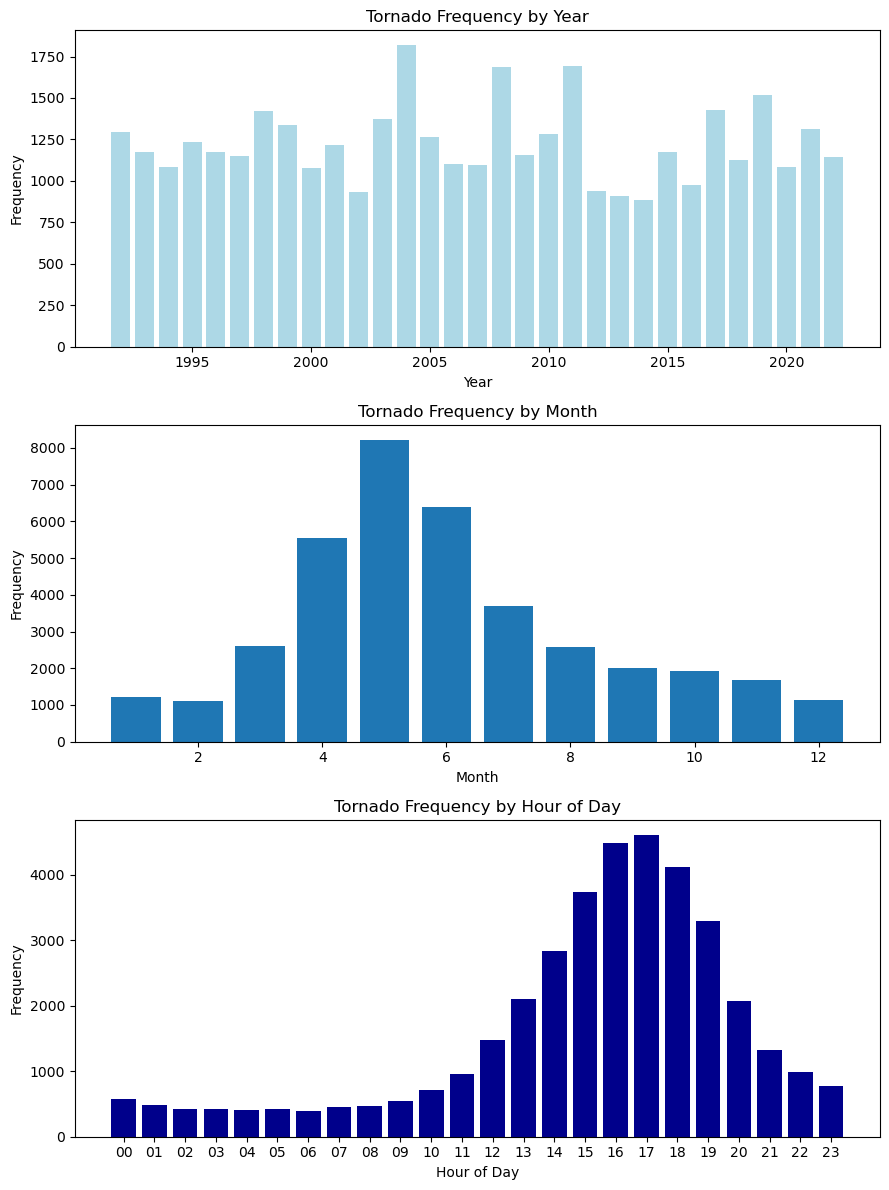

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12))

#year
axes[0].bar(year_counts.index, year_counts.values, color='lightblue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tornado Frequency by Year')

#month
axes[1].bar(month_counts.index, month_counts.values)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Tornado Frequency by Month')

#hour
axes[2].bar(hour_counts.index, hour_counts.values, color='darkblue')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Tornado Frequency by Hour of Day')

plt.tight_layout()
plt.show()

In [73]:
grouped_data = df.groupby('mag').agg({'inj': 'sum', 'fat': 'sum'}).reset_index()
grouped_data = grouped_data[grouped_data['mag'] != -9]

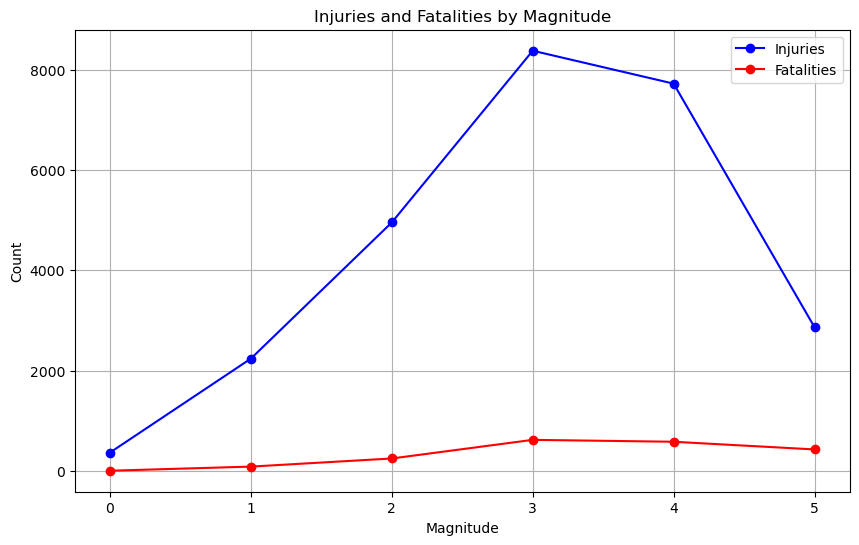

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['mag'], grouped_data['inj'], marker='o', linestyle='-', color='blue', label='Injuries')
plt.plot(grouped_data['mag'], grouped_data['fat'], marker='o', linestyle='-', color='red', label='Fatalities')

plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Injuries and Fatalities by Magnitude')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
Idea: take the hourly wind speed and pressure leading up to a tornado (all hours of the day before/inc when it starts)
and use a model to predict the outcome (mag, inj, length, fat) based on that weather data. since most tornadoes happen 4-6pm, this gives us 
a whole day of weather data leading up to them

In [ ]:
other idea: get average of several conditions from morning until afternoon (static) and use the combination of averages to predict
information on tornadoes that occur from 3pm to 6pm (mosts common time)

In [19]:
df1 = pd.read_csv('data/weather1.csv')

In [18]:
df2 = pd.read_csv('data/weather2.csv')

In [282]:
df3 = pd.read_csv('data/weather3.csv')

In [284]:
df4 = pd.read_csv('data/weather4.csv')

In [123]:
df = pd.concat([df1,df2],ignore_index=True)

In [124]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [125]:
df['hour'] = df['time'].str[:2].astype(int)

In [74]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.33,-88.45,39.33,-88.40,2.5,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17
1,1996,10,21,1996-10-21,07:00:00,TX,48,1,0,0,0.04,0.0,32.40,-97.80,32.40,-97.80,0.5,40,12.924953,27.804028,1003.200012,16.676977,32.908016,1004.099976,20.674158,37.550602,1004.599976,24.122683,41.425034,1004.799988,24.216522,41.750687,1005.299988,23.576563,40.541180,1004.900024,22.424271,38.896660,1005.200012,20.929596,36.302925,1005.099976,18.448023,32.023815,1005.599976,15.584300,27.047956,1005.700012,6.489992,14.336861,1005.900024,7.695920,16.854767,1006.299988,10.514218,20.523157,1007.700012,9.360001,16.923830,1008.400024,12.101570,20.188908,1008.799988,5.495161,8.435069,1009.599976,2.902413,3.758510,1008.799988,3.600000,4.072935,1008.900024,6.297428,8.287822,1009.000000,6.379216,8.311245,1007.700012,3.976330,5.411986,1006.900024,1.938659,2.414953,1006.299988,10.829958,14.241630,1005.799988,15.937878,23.452555,1007.200012,7
2,1996,10,21,1996-10-21,08:35:00,TX,48,1,7,0,3.00,0.0,32.77,-96.78,32.77,-96.78,0.5,50,19.586117,33.893574,1004.099976,23.688984,39.557430,1004.700012,26.368616,43.211998,1005.200012,28.551426,45.047493,1005.599976,29.250967,45.468437,1006.299988,30.035742,47.446304,1006.000000,27.155552,47.373863,1006.400024,27.820337,43.631348,1006.099976,26.437336,41.859192,1006.299988,25.562534,39.961620,1006.000000,16.071491,27.210379,1005.900024,14.494192,24.933735,1006.200012,13.320000,23.806318,1007.500000,16.199999,26.574244,1008.099976,12.303366,20.447239,1008.599976,7.568566,13.679999,1009.599976,5.154415,7.653705,1009.400024,6.877789,8.209263,1009.099976,10.990322,13.217443,1008.400024,10.948973,13.797912,1008.500000,14.400000

In [126]:
df = df[(df['hour'] >= 11) & (df['hour'] <= 22)]

In [76]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.33,-88.45,39.33,-88.40,2.5,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.00,0.0,31.73,-98.08,31.73,-98.08,0.1,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.04,0.0,33.17,-94.50,33.12,-94.15,22.0,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,12.434340,22.086521,1010.599976,14.512064,24.648829,1010.599976,14.154915,22.505037,1010.700012,13.339445,20.548401,1010.099976,13.627795,20.969805,1009.400024,13

In [127]:
#calculate average of 10hours leading up to tornado
#initialize columns
df['Average_Wind_Speed_10m'] = 0
df['Average_Wind_Speed_100m'] = 0
df['Average_Pressure_msl'] = 0

#iterate over each row to calculate the average
for index, row in df.iterrows():
    hour_value = row['hour']

    #calculate current hour index, and 9 hours before
    current_hour_index = (hour_value - 12) * 3
    preceding_hour_indices = [current_hour_index - i * 3 for i in range(1, 10)]

    #sum the values for the corresponding weather factors
    for i, factor in enumerate(['Wind_Speed_10m', 'Wind_Speed_100m', 'Pressure_msl']):
        current_col = f"{hour_value:02d}:00_{factor}"
        preceding_cols = [f"{(hour_value - i):02d}:00_{factor}" for i in range(1, 10)]
        
        #calculate the sum for the current row and factor
        sum_value = row[current_col] + sum(row[preceding_col] for preceding_col in preceding_cols)
        
        #calculate the average
        average_value = sum_value / 10
        
        #assign the average to the corresponding new column
        df.at[index, f'Average_{factor}'] = average_value

C:\Users\15199\AppData\Local\Temp\ipykernel_23732\691249982.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.433741092681885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'Average_{factor}'] = average_value
C:\Users\15199\AppData\Local\Temp\ipykernel_23732\691249982.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '31.50586814880371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'Average_{factor}'] = average_value
C:\Users\15199\AppData\Local\Temp\ipykernel_23732\691249982.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1008.3299926757812' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'Aver

In [ ]:
#since most tornadoes happen around 4-5 pm, I was able to drop late night and early morning tornadoes without losing too much data
#this makes it easier to get hours leading up to the torndao, and also gives a more reasonable 'baseline'
#eg we want to understand the average weather from the morning of the storm, up until the storm, as opposed to having to look at the weather 
#from late last night until 11am, for example

In [128]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour,Average_Wind_Speed_10m,Average_Wind_Speed_100m,Average_Pressure_msl
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.33,-88.45,39.33,-88.40,2.5,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17,18.433741,31.505868,1008.329993
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.00,0.0,31.73,-98.08,31.73,-98.08,0.1,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14,17.939456,29.300908,1006.639996
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.04,0.0,33.17,-94.50,33.12,-94.15,22.0,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,12.434340,22.086521,1010.59997

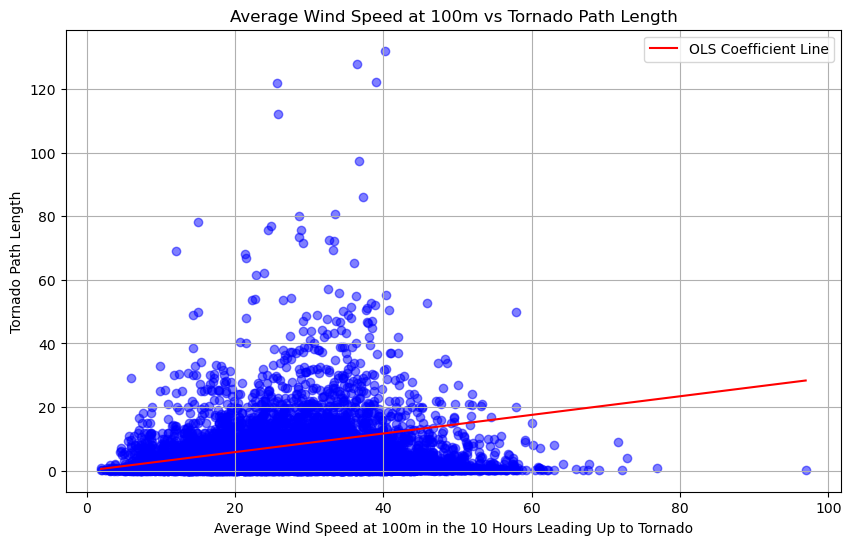

In [310]:
coefficient_value = results.params['Average_Wind_Speed_100m']

wind_speed_values = np.linspace(min(df['Average_Wind_Speed_100m']), max(df['Average_Wind_Speed_100m']), 100)

predicted_path_length = coefficient_value * wind_speed_values

plt.figure(figsize=(10, 6))
plt.scatter(df['Average_Wind_Speed_100m'], df['len'], color='blue', alpha=0.5)

plt.plot(wind_speed_values, predicted_path_length, color='red', label='OLS Coefficient Line')

plt.title('Average Wind Speed at 100m vs Tornado Path Length')
plt.xlabel('Average Wind Speed at 100m in the 10 Hours Leading Up to Tornado')
plt.ylabel('Tornado Path Length')
plt.legend()
plt.grid(True)

plt.show()

OLS experimenting for predictable variables:

Length

In [308]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['len']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

In [309]:
results.summary()
#Len gives p values of 0.00 for each of my weather conditions, making it a strong contender to predict
#according to this, higher wins speeds at 100m result in a longer tornado path, while higher wind speeds at 10m result in a shorter path
#This likely has to do with wind shear - the difference in wind speeds and directions at different altitudes are a large factor in the formation of a tornado
#Also, lower pressure (at mean sea level) is predictive of a longer tornado

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    len   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     147.3
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           3.04e-94
Time:                        13:34:54   Log-Likelihood:                -54792.
No. Observations:               16988   AIC:                         1.096e+05
Df Residuals:                   16984   BIC:                         1.096e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      93.9345     10.159      9.246      0.000      74.021     113.848
Average_Wind_Speed_10m     -0.3815      0.030    -12.888      0.000      -0.439      -0.323
Average_Wind_Speed_100m     0.2925      0.020     14.973      0.000       0.254       0.331
Average_Pressure_msl       -0.0917      0.010     -9.162      0.000      -0.111      -0.072
==============================================================================
Omnibus:                    20778.178   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4192457.690
Skew:                           6.499   Prob(JB):                         0.00
Kurtosis:                      78.855   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Width

In [143]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['wid']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()
results.summary()
#very similar results for the width of the path, unsurprisingly

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wid   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     31.93
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.61e-20
Time:                        12:58:34   Log-Likelihood:                -56538.
No. Observations:                8605   AIC:                         1.131e+05
Df Residuals:                    8601   BIC:                         1.131e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2745.8168    409.957      6.698      0.000    1942.204    3549.430
Average_Wind_Speed_10m     -4.7956      1.138     -4.213      0.000      -7.027      -2.564
Average_Wind_Speed_100m     3.7411      0.757      4.941      0.000       2.257       5.225
Average_Pressure_msl       -2.6464      0.404     -6.551      0.000      -3.438      -1.855
==============================================================================
Omnibus:                     9026.773   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           588912.147
Skew:                           5.324   Prob(JB):                         0.00
Kurtosis:                      42.104   Cond. No.                     2.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [311]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['len']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
results = model.fit()

y_pred = results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 33.59566097473251
Root Mean Squared Error (RMSE): 5.7961764099044215
Mean Absolute Error (MAE): 3.1447907672862
R-squared (R2) Score: 0.030406078381968626


In [194]:
#OLS is not very effective for predicting

Classification

GBM

In [360]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [328]:
gbmclass = GradientBoostingClassifier(random_state=42)
gbmclass.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [329]:
y_pred_gbm = gbmclass.predict(X_test)

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("GBM Accuracy:", accuracy_gbm)

print("GBM Classification Report:")
print(classification_report(y_test, y_pred_gbm))

GBM Accuracy: 0.6489111241907004
GBM Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      2207
           1       0.50      0.01      0.02       838
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        86

    accuracy                           0.65      3398
   macro avg       0.29      0.25      0.20      3398
weighted avg       0.55      0.65      0.52      3398



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest

In [158]:
rfclass = RandomForestClassifier(random_state=42)
rfclass.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [161]:
y_pred = rfclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6502033701336433
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      1158
           1       0.35      0.18      0.24       397
           2       0.26      0.07      0.11       118
           3       0.17      0.02      0.04        42
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1

    accuracy                           0.65      1721
   macro avg       0.25      0.19      0.20      1721
weighted avg       0.57      0.65      0.59      1721



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#even the most accurate classifier cannot predict the 5 or 4 category, because there are so little of them - i will combine these high severity ones
#into one group for better classification

SVM

In [330]:
svmclass = SVC(kernel='rbf', random_state=42)
svmclass.fit(X_train, y_train)

SVC(random_state=42)

In [331]:
y_pred_svm = svmclass.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.6494997057092408
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      2207
           1       0.00      0.00      0.00       838
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        86

    accuracy                           0.65      3398
   macro avg       0.16      0.25      0.20      3398
weighted avg       0.42      0.65      0.51      3398



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
#try with more data
#so far random forest is good!
#maybe combine 4 & 5 into "high severity" since they are both very low

In [285]:
df = pd.concat([df1,df2,df3,df4],ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['hour'] = df['time'].str[:2].astype(int)

In [287]:
df = df[(df['hour'] >= 11) & (df['hour'] <= 22)]

In [289]:
#calculate average of 10hours leading up to tornado
#initialize columns
df['Average_Wind_Speed_10m'] = 0
df['Average_Wind_Speed_100m'] = 0
df['Average_Pressure_msl'] = 0

#iterate over each row to calculate the average
for index, row in df.iterrows():
    hour_value = row['hour']

    #calculate current hour index, and 9 hours before
    current_hour_index = (hour_value - 12) * 3
    preceding_hour_indices = [current_hour_index - i * 3 for i in range(1, 10)]

    #sum the values for the corresponding weather factors
    for i, factor in enumerate(['Wind_Speed_10m', 'Wind_Speed_100m', 'Pressure_msl']):
        current_col = f"{hour_value:02d}:00_{factor}"
        preceding_cols = [f"{(hour_value - i):02d}:00_{factor}" for i in range(1, 10)]
        
        #calculate the sum for the current row and factor
        sum_value = row[current_col] + sum(row[preceding_col] for preceding_col in preceding_cols)
        
        #calculate the average
        average_value = sum_value / 10
        
        #assign the average to the corresponding new column
        df.at[index, f'Average_{factor}'] = average_value

C:\Users\15199\AppData\Local\Temp\ipykernel_23732\1281024292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average_Wind_Speed_10m'] = 0
C:\Users\15199\AppData\Local\Temp\ipykernel_23732\1281024292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average_Wind_Speed_100m'] = 0
C:\Users\15199\AppData\Local\Temp\ipykernel_23732\1281024292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [290]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour,Average_Wind_Speed_10m,Average_Wind_Speed_100m,Average_Pressure_msl
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.000,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17,18.433741,31.505868,1008.329993
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.000,0.0,31.7300,-98.0800,31.7300,-98.0800,0.10,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14,17.939456,29.300908,1006.639996
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.040,0.0,33.1700,-94.5000,33.1200,-94.1500,22.00,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,

In [376]:
df.value_counts('mag')

mag
0    10982
1     4256
2     1264
3      486
Name: count, dtype: int64

In [294]:
df['mag'] = df['mag'].replace(5, 4)

C:\Users\15199\AppData\Local\Temp\ipykernel_23732\2071592815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag'] = df['mag'].replace(5, 4)


In [299]:
df['mag'] = df['mag'].replace(4, 3)

C:\Users\15199\AppData\Local\Temp\ipykernel_23732\2520973310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag'] = df['mag'].replace(4, 3)


In [316]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [301]:
rfclass = RandomForestClassifier(random_state=42)
rfclass.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [349]:
'''
Base random forest - 62%

''

In [302]:
y_pred = rfclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6194820482636845
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2207
           1       0.33      0.16      0.22       838
           2       0.16      0.04      0.07       267
           3       0.12      0.02      0.04        86

    accuracy                           0.62      3398
   macro avg       0.32      0.28      0.27      3398
weighted avg       0.54      0.62      0.56      3398



In [ ]:
'''
hyper parameter testing random forest

In [305]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.6494997057092408


In [332]:
param_dist = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

rf_classifier = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\15199\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 121}
Accuracy: 0.6506768687463214


In [ ]:
'''
testing best parameters random forest - 65% but only rpedicting magnitude 0 or 1

In [341]:
tunedRFclass = RandomForestClassifier(bootstrap=True, 
                                       max_depth=30, 
                                       max_features='auto', 
                                       min_samples_leaf=15, 
                                       min_samples_split=12, 
                                       n_estimators=121)

In [342]:
tunedRFclass.fit(X_train,y_train)

C:\Users\15199\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=30, max_features='auto', min_samples_leaf=15,
                       min_samples_split=12, n_estimators=121)

In [343]:
y_pred = tunedRFclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.650088287227781
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.79      2207
           1       0.42      0.02      0.04       838
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        86

    accuracy                           0.65      3398
   macro avg       0.27      0.25      0.21      3398
weighted avg       0.53      0.65      0.52      3398



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'''
testing oversampling random forest

In [344]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [345]:
rfoversampled = RandomForestClassifier(max_depth=10, 
                                       min_samples_leaf=1, 
                                       min_samples_split=2, 
                                       n_estimators=300)


rfoversampled.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(max_depth=10, n_estimators=300)

In [346]:
y_pred = rfoversampled.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.31489111241907003
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.38      0.51      2207
           1       0.29      0.17      0.22       838
           2       0.08      0.14      0.10       267
           3       0.04      0.63      0.08        86

    accuracy                           0.31      3398
   macro avg       0.29      0.33      0.22      3398
weighted avg       0.57      0.31      0.39      3398



In [ ]:
'''
testing class weighting random forest - 62%

In [347]:
class_weights = {0: 1, 1: 2, 2: 4, 3: 6}

weightedrf = RandomForestClassifier()

weightedrf.fit(X_train, y_train)

RandomForestClassifier()

In [348]:
y_pred = weightedrf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6247792819305473
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2207
           1       0.34      0.16      0.22       838
           2       0.15      0.04      0.06       267
           3       0.18      0.03      0.06        86

    accuracy                           0.62      3398
   macro avg       0.34      0.28      0.28      3398
weighted avg       0.54      0.62      0.56      3398



In [ ]:
'''
random cv trying different weights for random forest

In [351]:
params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300],
    'class_weight': [{0: 1, 1: w1, 2: w2, 3: w3} for w1 in [1, 2] for w2 in range(1, 6) for w3 in range(1, 7)]
}


rfweightedcv = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rfweightedcv, param_distributions=params, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'class_weight': {0: 1, 1: 1, 2: 1, 3: 2}}
Accuracy: 0.6494997057092408


In [ ]:
'''
xgboost
experiment with xgboost a lot

In [362]:
params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'verbosity': 1,
}

xgb_classifier = xgb.XGBClassifier(**params)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6377280753384343


In [363]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78      2207
           1       0.33      0.08      0.13       838
           2       0.20      0.01      0.03       267
           3       0.00      0.00      0.00        86

    accuracy                           0.64      3398
   macro avg       0.30      0.26      0.23      3398
weighted avg       0.53      0.64      0.54      3398



In [366]:
'''lgbm is good!!

In [378]:
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

y_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)


report = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 3
[LightGBM] [Info] Start training from score -0.437427
[LightGBM] [Info] Start training from score -1.380279
[LightGBM] [Info] Start training from score -2.612339
[LightGBM] [Info] Start training from score -3.525625
Accuracy: 0.6439081812831077
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.98      0.78      2207
           1       0.29      0.03      0.06       838
           2       0.40      0.01      0.01       267
           3       0.17      0.01      0.02        86

    accuracy                           0.64      3398
   macro avg       0.38      0.26      0.22      3398
weighted avg       0.53      0.64      0.53      3398



In [381]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour,Average_Wind_Speed_10m,Average_Wind_Speed_100m,Average_Pressure_msl
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.000,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17,18.433741,31.505868,1008.329993
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.000,0.0,31.7300,-98.0800,31.7300,-98.0800,0.10,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14,17.939456,29.300908,1006.639996
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.040,0.0,33.1700,-94.5000,33.1200,-94.1500,22.00,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,

In [383]:
df.value_counts('mag')

mag
0    10982
1     4256
2     1264
3      486
Name: count, dtype: int64

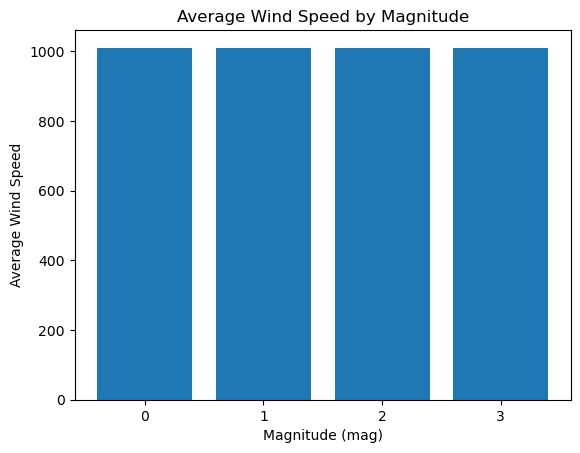

In [386]:
average_wind_speed_by_mag = df.groupby('mag')['Average_Pressure_msl'].mean()

# Plot bar chart
plt.bar(average_wind_speed_by_mag.index, average_wind_speed_by_mag.values)
plt.xlabel('Magnitude (mag)')
plt.ylabel('Average Wind Speed')
plt.title('Average Wind Speed by Magnitude')
plt.xticks(range(4))  # Set x-axis ticks to 0, 1, 2, 3
plt.show()